In [1]:
import glob
import os
import nibabel as nib
import numpy as np
import cv2
import tensorflow as tf

def preprocess_data(data_dir):
    files = glob.glob(os.path.join(data_dir, '*.nii'))
    data = [nib.load(f).get_fdata() for f in files]
    slices = []

    max_shape = [0, 0]
    for d in data:
        for i in range(d.shape[2]):
            slice = d[:, :, i]
            slice = (slice - slice.mean()) / slice.std()
            slice_shape = cv2.resize(slice, (240,240), interpolation=cv2.INTER_CUBIC).shape[:2]
            max_shape = np.maximum(max_shape, slice_shape)

    for d in data:
        for i in range(d.shape[2]):
            slice = d[:, :, i]
            slice = (slice - slice.mean()) / slice.std()
            slice = cv2.resize(slice, (max_shape[1], max_shape[0]), interpolation=cv2.INTER_CUBIC)
            slice = np.uint8(slice)
            slice = cv2.cvtColor(slice, cv2.COLOR_GRAY2RGB)
            slices.append(slice)

    print("Original data shape: ", data[0].shape)
    print("Resized and converted data shape: ", slices[0].shape)
    return slices

def prepare_data(slices):
    # Convert data to float32 and normalize
    slices = np.array(slices, dtype='float32') / 255.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    # Subtract the mean
    slices = slices - mean
    # Divide by the standard deviation
    slices = slices / std
    return slices

mci_data = preprocess_data('D:\\MCI\\MCI_folder\\MCI_preprocess')
mci_data = prepare_data(mci_data)

ad_data = preprocess_data('D:\AD\AD_folder\AD_preprocess')
ad_data = prepare_data(ad_data)

Original data shape:  (248, 248, 248)
Resized and converted data shape:  (240, 240, 3)
Original data shape:  (256, 256, 48, 1)
Resized and converted data shape:  (240, 240, 3)


In [2]:
import numpy as np
import cv2

def rescale_data(mci_data, ad_data):
    mci_samples = mci_data.shape[0]
    ad_samples = ad_data.shape[0]
    num_samples = min(mci_samples, ad_samples)

    mci_data = mci_data[:num_samples, :, :, :]
    ad_data = ad_data[:num_samples, :, :, :]

# Resize the data to fit the input size of EfficientNetB2
    mci_data = np.array([cv2.resize(slice, (240, 240), interpolation=cv2.INTER_CUBIC) for slice in mci_data])
    ad_data = np.array([cv2.resize(slice, (240, 240), interpolation=cv2.INTER_CUBIC) for slice in ad_data])

    return mci_data, ad_data
mci_data, ad_data = rescale_data(mci_data, ad_data)

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split

data = np.concatenate((mci_data, ad_data), axis=0)
labels = np.concatenate((np.zeros(len(mci_data)), np.ones(len(ad_data))))

def split_data(data, labels):

    # Resize the data to (240, 240, 3)
    data = np.array([np.resize(img, (240, 240, 3)) for img in data])

    # Randomly split the data into train, test, and validation sets
    train_data, test_val_data, train_labels, test_val_labels = train_test_split(data, labels, test_size=0.3, random_state=0, stratify=labels)
    test_data, val_data, test_labels, val_labels = train_test_split(test_val_data, test_val_labels, test_size=0.5, random_state=0, stratify=test_val_labels)

    return train_data, train_labels, test_data, test_labels, val_data, val_labels

train_data, train_labels, test_data, test_labels, val_data, val_labels = split_data(data, labels)
print("Train data shape: ", train_data.shape)
print("Train labels shape: ", train_labels.shape)
print("Test data shape: ", test_data.shape)
print("Test labels shape: ", test_labels.shape)
print("Validation data shape: ", val_data.shape)
print("Validation labels shape: ", val_labels.shape)

Train data shape:  (688, 240, 240, 3)
Train labels shape:  (688,)
Test data shape:  (148, 240, 240, 3)
Test labels shape:  (148,)
Validation data shape:  (148, 240, 240, 3)
Validation labels shape:  (148,)


In [4]:
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the pre-trained EfficientNetB2 model and remove the top layer
base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(240, 240, 3))
x = base_model.output

# Add a global average pooling layer and a dense layer
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Freeze all the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Initialize the data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

# Fit the model using the generator
history = model.fit(
    train_data, train_labels,
    batch_size=32,
    epochs=10,
    validation_data=(val_data, val_labels)
)

f:\File Visual studio\File python 3.10\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
22/22 [==============================] - 71s 3s/step - loss: 0.7003 - accuracy: 0.4913 - val_loss: 0.6957 - val_accuracy: 0.5000
Epoch 2/10
22/22 [==============================] - 49s 2s/step - loss: 0.6951 - accuracy: 0.5058 - val_loss: 0.6944 - val_accuracy: 0.3851
Epoch 3/10
22/22 [==============================] - 62s 3s/step - loss: 0.6949 - accuracy: 0.4651 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 4/10
22/22 [==============================] - 58s 3s/step - loss: 0.6954 - accuracy: 0.4608 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 5/10
22/22 [==============================] - 59s 3s/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6921 - val_accuracy: 0.6149
Epoch 6/10
22/22 [==============================] - 52s 2s/step - loss: 0.6923 - accuracy: 0.5131 - val_loss: 0.6911 - val_accuracy: 0.5000
Epoch 7/10
22/22 [==============================] - 55s 3s/step - loss: 0.6945 - accuracy: 0.4855 - val_loss: 0.6906 - val_accuracy: 0.5000
Epoch 8/10
22/22 [==

In [5]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_accuracy * 100, "%")

5/5 [==============================] - 13s 2s/step - loss: 0.6890 - accuracy: 0.8514
Test Loss:  0.6890039443969727
Test Accuracy:  85.13513803482056 %


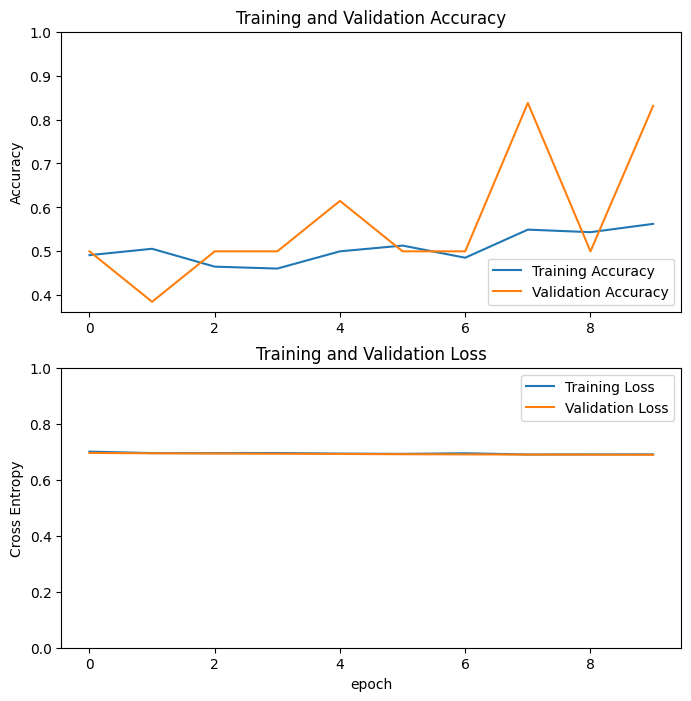

In [6]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [7]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print("Test accuracy: {:.2f}%".format(test_accuracy * 100))

# Make predictions on the test data
predictions = model.predict(test_data)

# Round the predictions to 0 or 1
rounded_predictions = np.round(predictions)

# Calculate the accuracy of the model
accuracy = np.mean(rounded_predictions == test_labels)
print("Prediction accuracy: {:.2f}%".format(accuracy * 100))

5/5 [==============================] - 13s 2s/step - loss: 0.6890 - accuracy: 0.8514
Test accuracy: 85.14%
Prediction accuracy: 50.00%


In [34]:
train_predictions = model.predict(train_data)
train_labels_predicted = np.round(train_predictions)
train_labels_predicted = np.where(train_labels_predicted < 0.5, 'MCI', 'AD')
print(train_labels_predicted[:10])

[['AD']
 ['AD']
 ['AD']
 ['AD']
 ['AD']
 ['AD']
 ['AD']
 ['MCI']
 ['AD']
 ['AD']]


In [35]:
# Predicting the test set results
y_pred = model.predict(test_data)
y_pred = (y_pred > 0.5)
print(y_pred[:5])

[[False]
 [ True]
 [ True]
 [ True]
 [False]]


In [43]:
from sklearn.metrics import accuracy_score

train_predictions = model.predict(train_data)
train_labels_predicted = np.round(train_predictions)
train_labels_predicted = np.where(train_labels_predicted < 0.5, 0, 1)

import pandas as pd
data_prediction = list(zip(train_labels, train_labels_predicted))
data_prediction = pd.DataFrame(data_prediction, columns=['True Labels', 'Predicted Labels'])
print(data_prediction.head(20))

accuracy = accuracy_score(train_labels, train_labels_predicted)
print("Accuracy: {:.2f}%".format(accuracy * 100))

    True Labels Predicted Labels
0             0              [1]
1             0              [1]
2             0              [1]
3             1              [1]
4             1              [1]
5             1              [1]
6             1              [1]
7             0              [0]
8             0              [1]
9             1              [1]
10            0              [0]
11            0              [0]
12            1              [1]
13            1              [1]
14            0              [0]
15            1              [1]
16            1              [1]
17            0              [0]
18            1              [1]
19            0              [1]
Accuracy: 82.70%
